# Tratar datos crudos para meter a base de datos

En este caso hemos descargado imagenes de la Api de Roboflow, de datasets como ppt3 Computer Vision Project, Hard Hat Helmet Detection Computer Vision Project, aprox - 40000 de las cuales fuimos eliminando, hasta quedarnos con 3200 Clase Casco, y 5200 clase casco.

Hicimos gran parte del Dataset a mano. de 1000 imagenes Aprox, las unimos y hicimos reshape, la mayoria venian en 640x640. Esto para poner cargarlas mas facilmente sin perder calidad con Open CV.

Despues de eso segmentamos los datos hicimos tres transformaciones de brillo, zoom, y rotacion para 3734 imagenes de CLASE - Casco que dio en 3734 imagenes x 5 transformaciones por imagen + 3734 imagenes originales , nos da 22,404.

CLASE- No_casco 5628 imagenes x 3 transfomaciones por imagen + 5628, nos da 22,512

Tamaño total de DATASET = 44,916

Esto lo hice asi para que las clases estuvieran balancedas, y tener menos problemas.

CLASE- No_casco 22,512 , CLASE - Casco 22,404. Con el siguiente codigo hicimos reshape a las imagenes de
640 x 640 a 180 x 180.

In [ ]:
import cv2
import os

# Rutas de las carpetas
carpetas = [
    r"C:\Users\Andres\Desktop\Data\Newalldata\Newdata\casco",
    r"C:\Users\Andres\Desktop\Data\Newalldata\Newdata\no_casco"
]

for carpeta in carpetas:
    print(f"\nProcesando carpeta: {carpeta}")
    for archivo in os.listdir(carpeta):
        ruta_archivo = os.path.join(carpeta, archivo)
        imagen = cv2.imread(ruta_archivo)

        if imagen is not None:
            alto, ancho = imagen.shape[:2]

            if ancho != 180 or alto != 180:
                imagen_redimensionada = cv2.resize(imagen, (180, 180))
                cv2.imwrite(ruta_archivo, imagen_redimensionada)
                print(f"Redimensionada y guardada: {archivo}")
            else:
                print(f"Ya está en 180x180: {archivo}")
        else:
            print(f"No es una imagen válida: {archivo}")


Procesando carpeta: C:\Users\Andres\Desktop\Data\Newalldata\Newdata\casco
Redimensionada y guardada: frame_0000.jpg
Redimensionada y guardada: frame_0001.jpg
Redimensionada y guardada: frame_0002.jpg
Redimensionada y guardada: frame_0003.jpg
Redimensionada y guardada: frame_0004.jpg
Redimensionada y guardada: frame_0005.jpg
Redimensionada y guardada: frame_0006.jpg
Redimensionada y guardada: frame_0007.jpg
Redimensionada y guardada: frame_0008.jpg
Redimensionada y guardada: frame_0009.jpg
Redimensionada y guardada: frame_0010.jpg
Redimensionada y guardada: frame_0011.jpg
Redimensionada y guardada: frame_0012.jpg
Redimensionada y guardada: frame_0013.jpg
Redimensionada y guardada: frame_0014.jpg
Redimensionada y guardada: frame_0015.jpg
Redimensionada y guardada: frame_0016.jpg
Redimensionada y guardada: frame_0017.jpg
Redimensionada y guardada: frame_0018.jpg
Redimensionada y guardada: frame_0019.jpg
Redimensionada y guardada: frame_0020.jpg
Redimensionada y guardada: frame_0021.jpg
R

Ya habiendo redimensionado las imagenes procederemos a dividirlas en 3 vectores, ya que cada imagen es un vector 128x128x3, que reprecenta cada 128x128x1 vector un color "Verde, Azul, Rojo". Nosotros usaremos Redes CNN, con convoluciones que son buenas para imagenes pero en futuras actualizaciones. Utilizaremos este formato para entrenar modelos como KNN Vecinos cercados o un arbol de desiciones.

Convirtiendo cada vector 128x128x1 en unvector plano rojo_vector.shape = (16384,) verde_vector.shape = (16384,)

azul_vector.shape = (16384,).

In [ ]:
import os
import cv2
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Combinaciones por clase
combinaciones = {
    'No_casco': [
        ImageDataGenerator(horizontal_flip=True, shear_range=5),
        ImageDataGenerator(rotation_range=10, brightness_range=(1.2, 1.5)),
        ImageDataGenerator(rotation_range=15, zoom_range=[0.7, 1.4]),
    ],
    'Casco': [
        ImageDataGenerator(rotation_range=30, horizontal_flip=True),
        ImageDataGenerator(rotation_range=10, brightness_range=(1.2, 1.5)),
        ImageDataGenerator(brightness_range=(0.5, 0.8), rotation_range=15),
        ImageDataGenerator(width_shift_range=0.2, shear_range=5),
        ImageDataGenerator(horizontal_flip=True, zoom_range=[0.7, 1.4]),
    ]
}

def cargar_imagenes(ruta):
    imagenes = []
    for archivo in os.listdir(ruta):
        path = os.path.join(ruta, archivo)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            imagenes.append((img, archivo))
    return imagenes

def aumentar_y_guardar(imagenes, datagens, salida, n_transform):
    os.makedirs(salida, exist_ok=True)

    for img, nombre in imagenes:
        base = os.path.splitext(nombre)[0]
        cv2.imwrite(os.path.join(salida, f"{base}_original.jpg"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        for i, gen in enumerate(random.sample(datagens, n_transform)):
            aug = next(gen.flow(np.expand_dims(img, 0), batch_size=1))[0].astype(np.uint8)
            cv2.imwrite(os.path.join(salida, f"{base}_aug{i}.jpg"), cv2.cvtColor(aug, cv2.COLOR_RGB2BGR))

    print(f"✅ {len(imagenes)} imágenes procesadas y guardadas en: {salida}")

# Rutas base
base_origen = r'C:\Users\Andres\Desktop\Data\Newalldata\Newdata'
base_salida = r'C:\Users\Andres\Desktop\Data\Newalldata\dataset_transformado'

# Ejecutar para cada clase
for clase, datagens in combinaciones.items():
    origen = os.path.join(base_origen, clase)
    salida = os.path.join(base_salida, clase)
    imagenes = cargar_imagenes(origen)
    print(f"\nProcesando clase: {clase}")
    aumentar_y_guardar(imagenes, datagens, salida, n_transform=5 if clase == 'Casco' else 3)

# Cargar csv y almacenar en SQLite

En esta parte convertimos las imagenes en tres vectores Azul, Verde y Rojo

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

# Carpetas por clase
carpetas = {
    "No_casco": "C:\\Users\\Andre\\Downloads\\project\\dataset_transformado\\No_casco",
    "Casco": "C:\\Users\\Andre\\Downloads\\project\\dataset_transformado\\Casco"
}

datos = []

for clase, carpeta in carpetas.items():
    imagenes = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

    for nombre_imagen in imagenes:
        ruta = os.path.join(carpeta, nombre_imagen)
        imagen_bgr = cv2.imread(ruta)

        if imagen_bgr is None:
            print(f"No se pudo leer: {ruta}")
            continue

        imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)
        imagen_rgb = cv2.resize(imagen_rgb, (128, 128))

        r = imagen_rgb[:, :, 0].flatten()
        g = imagen_rgb[:, :, 1].flatten()
        b = imagen_rgb[:, :, 2].flatten()

        r_str = ",".join(map(str, r))
        g_str = ",".join(map(str, g))
        b_str = ",".join(map(str, b))

        datos.append({
            "nombre_imagen": nombre_imagen,
            "clase": clase,
            "rojo": r_str,
            "verde": g_str,
            "azul": b_str
        })

# Crear DataFrame
df = pd.DataFrame(datos)



print("Proceso completado con ambas clases.")

Proceso completado con ambas clases.


Gurdamos en CSV

In [2]:
# Guardar como CSV
df.to_csv("imagenes_rgb_clasificadas.csv", index=False)

In [4]:
df.shape

(44916, 5)

In [3]:
df.head(20)

,nombre_imagen,clase,rojo,verde,azul
0,0001 (2)_aug0.jpg,No_casco,"209,209,208,206,205,204,205,205,203,204,205,20...","211,211,210,208,207,206,207,207,205,206,207,20...","206,206,205,203,202,201,202,202,200,201,204,20..."
1,0001 (2)_aug1.jpg,No_casco,"255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25..."
2,0001 (2)_aug2.jpg,No_casco,"246,246,246,246,246,246,246,246,246,246,248,24...","250,250,250,250,250,250,250,250,250,250,249,24...","251,251,251,251,251,251,251,251,251,251,251,25..."
3,0001 (2)_original.jpg,No_casco,"244,244,244,245,244,245,247,248,249,247,247,24...","250,250,250,251,250,251,251,252,253,251,248,24...","248,248,248,249,250,251,252,253,254,252,250,25..."
4,0001 (3)_aug0.jpg,No_casco,"247,247,248,248,249,249,250,250,249,250,249,24...","248,248,250,250,251,251,250,250,250,251,251,25...","250,250,249,249,250,250,248,248,245,246,246,24..."
5,0001 (3)_aug1.jpg,No_casco,"248,248,248,248,248,247,247,247,248,248,247,24...","249,249,249,249,249,248,248,248,249,249,248,24...","251,251,251,251,251,250,250,250,251,251,250,25..."
6,0001 (3)_aug2.jpg,No_casco,"255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25..."
7,0001 (3)_original.jpg,No_casco,"248,248,248,248,248,247,247,247,247,248,248,24...","249,249,249,249,249,248,248,248,248,249,250,25...","251,251,251,251,251,250,250,250,250,251,249,25..."
8,0001 (4)_aug0.jpg,No_casco,"255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25..."
9,0001 (4)_aug1.jpg,No_casco,"178,178,180,180,180,180,182,182,187,188,190,19...","191,191,191,191,190,190,189,189,192,193,192,19...","182,182,183,183,182,182,182,182,186,187,187,18..."


In [5]:
import pandas as pd
df = pd.read_csv("imagenes_rgb_clasificadas.csv", nrows=10)
print(df.head())

           nombre_imagen     clase  \
0      0001 (2)_aug0.jpg  No_casco   
1      0001 (2)_aug1.jpg  No_casco   
2      0001 (2)_aug2.jpg  No_casco   
3  0001 (2)_original.jpg  No_casco   
4      0001 (3)_aug0.jpg  No_casco   

                                                rojo  \
0  209,209,208,206,205,204,205,205,203,204,205,20...   
1  255,255,255,255,255,255,255,255,255,255,255,25...   
2  246,246,246,246,246,246,246,246,246,246,248,24...   
3  244,244,244,245,244,245,247,248,249,247,247,24...   
4  247,247,248,248,249,249,250,250,249,250,249,24...   

                                               verde  \
0  211,211,210,208,207,206,207,207,205,206,207,20...   
1  255,255,255,255,255,255,255,255,255,255,255,25...   
2  250,250,250,250,250,250,250,250,250,250,249,24...   
3  250,250,250,251,250,251,251,252,253,251,248,24...   
4  248,248,250,250,251,251,250,250,250,251,251,25...   

                                                azul  
0  206,206,205,203,202,201,202,202,200,201

In [4]:
import pandas as pd
import sqlite3

#Cargar datos
df = pd.read_csv("imagenes_rgb_clasificadas.csv")


# Creacion de base de datos y guardado de datos

In [ ]:
import sqlite3

# Conexión a la base de datos (crea 'mibasedatos.db' si no existe)
conn = sqlite3.connect("mibasedatos.db")

# Guardar DataFrame 'df' en la tabla 'datos'
df.to_sql("datos", conn, if_exists="replace", index=False)

print("Ok. Datos almacenados.")

NameError: name 'df' is not defined

In [8]:
df

,nombre_imagen,clase,rojo,verde,azul
0,0001 (2)_aug0.jpg,No_casco,"209,209,208,206,205,204,205,205,203,204,205,20...","211,211,210,208,207,206,207,207,205,206,207,20...","206,206,205,203,202,201,202,202,200,201,204,20..."
1,0001 (2)_aug1.jpg,No_casco,"255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25...","255,255,255,255,255,255,255,255,255,255,255,25..."
2,0001 (2)_aug2.jpg,No_casco,"246,246,246,246,246,246,246,246,246,246,248,24...","250,250,250,250,250,250,250,250,250,250,249,24...","251,251,251,251,251,251,251,251,251,251,251,25..."
3,0001 (2)_original.jpg,No_casco,"244,244,244,245,244,245,247,248,249,247,247,24...","250,250,250,251,250,251,251,252,253,251,248,24...","248,248,248,249,250,251,252,253,254,252,250,25..."
4,0001 (3)_aug0.jpg,No_casco,"247,247,248,248,249,249,250,250,249,250,249,24...","248,248,250,250,251,251,250,250,250,251,251,25...","250,250,249,249,250,250,248,248,245,246,246,24..."
...,...,...,...,...,...
44911,imagen_99_aug1.jpg,Casco,"24,25,24,23,22,22,19,16,33,64,83,64,32,12,20,3...","24,25,24,23,22,22,19,16,31,62,83,64,32,12,20,3...","24,25,24,23,22,22,19,16,32,63,83,64,32,12,20,3..."
44912,imagen_99_aug2.jpg,Casco,"72,72,74,74,74,74,74,74,67,50,38,37,33,51,44,3...","76,76,75,75,75,75,75,75,67,50,38,37,33,51,45,3...","77,77,77,77,77,77,77,77,69,52,40,39,35,53,47,3..."
44913,imagen_99_aug3.jpg,Casco,"73,93,104,109,114,96,64,48,33,20,22,41,58,77,8...","65,85,96,101,106,88,56,40,28,15,17,36,53,72,84...","62,82,93,98,103,85,53,37,24,11,13,32,49,68,80,..."
44914,imagen_99_aug4.jpg,Casco,"40,41,40,38,37,39,39,37,33,26,28,17,16,7,26,86...","35,36,35,33,32,34,34,32,29,22,24,13,12,3,22,82...","32,33,32,30,29,31,31,29,26,19,21,10,9,0,19,79,..."


In [20]:
from sqlalchemy import create_engine

#Conexion
engine = create_engine('sqlite:///mibasedatos.db')



In [21]:
from sqlalchemy import create_engine, text
import pandas as pd

with engine.connect() as conn:
    result = conn.execute(text("SELECT*FROM datos LIMIT 5"))


query = "SELECT * FROM datos WHERE nombre_imagen > 100 LIMIT 10;"
df_filtered = pd.read_sql_query(query, engine)
print(df_filtered)
conn.close()


                      nombre_imagen     clase  \
0      IMG_20250605_175458_aug0.jpg  No_casco   
1      IMG_20250605_175458_aug1.jpg  No_casco   
2      IMG_20250605_175458_aug2.jpg  No_casco   
3  IMG_20250605_175458_original.jpg  No_casco   
4      IMG_20250605_175459_aug0.jpg  No_casco   
5      IMG_20250605_175459_aug1.jpg  No_casco   
6      IMG_20250605_175459_aug2.jpg  No_casco   
7  IMG_20250605_175459_original.jpg  No_casco   
8      IMG_20250605_175500_aug0.jpg  No_casco   
9      IMG_20250605_175500_aug1.jpg  No_casco   

                                                rojo  \
0  239,236,241,241,243,235,221,219,228,244,238,24...   
1  232,247,242,236,247,252,220,171,223,225,161,18...   
2  254,254,255,255,255,255,255,255,255,255,255,24...   
3  243,254,220,229,213,245,245,246,251,246,246,23...   
4  162,152,152,148,154,153,176,185,191,179,184,16...   
5  149,160,171,177,180,187,195,199,202,207,213,21...   
6  255,255,255,255,255,255,255,255,255,255,255,25...   
7  235,221,2

# Creacion de tabla

Insertando vectores a la tabla

In [14]:
import sqlite3
import json
import pandas as pd

# DataFrame  'df'  columnas: 'nombre_imagen', 'rojo', 'verde', 'azul'

conn = sqlite3.connect("mibasedatos.db")
cursor = conn.cursor()


cursor.execute("""
CREATE TABLE IF NOT EXISTS datos (
    nombre_imagen TEXT,
    clase TEXT,
    rojo INTEGER,
    verde INTEGER,
    azul INTEGER,
    vector TEXT
)
""")

# Insertar datos
for index, row in df.iterrows():
    nombre = row["nombre_imagen"]
    clase = row["clase"]
    vector = [row["rojo"], row["verde"], row["azul"]]
    vector_json = json.dumps(vector)

    cursor.execute(
    "INSERT INTO datos (nombre_imagen, clase, rojo, verde, azul, vector) VALUES (?, ?, ?, ?, ?, ?)",
    (nombre, clase, row["rojo"], row["verde"], row["azul"], vector_json)
)

conn.commit()
conn.close()

In [ ]:
# Verificar las tablas en la base de datos SQLite
import sqlite3

conn = sqlite3.connect("mibasedatos.db")
cursor = conn.cursor()

# Ver todas las tablas en la base de datos
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablas = cursor.fetchall()
print("Tablas:", tablas)

Tablas: [('datos',)]


Eliminamos tabla en caso de ser necesario

In [5]:
import sqlite3

conn = sqlite3.connect("mibasedatos.db")
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS datos")

conn.commit()
conn.close()

# EDA SQLite3 y Pandas

In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("mibasedatos.db")
df = pd.read_sql_query("SELECT * FROM datos", conn)
conn.close()

In [4]:
import sqlite3

conn = sqlite3.connect("mibasedatos.db")
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM datos")
print("Cantidad de filas:", cursor.fetchone()[0])

Cantidad de filas: 44916


In [ ]:
import pandas as pd
print(df.info())      # filas y tipos de datos
print(df.describe())  # estadísticas descriptivas de las columnas numéricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44916 entries, 0 to 44915
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   nombre_imagen  44916 non-null  object
 1   clase          44916 non-null  object
 2   rojo           44916 non-null  object
 3   verde          44916 non-null  object
 4   azul           44916 non-null  object
 5   vector         44916 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB
None
                nombre_imagen     clase  \
count                   44916     44916   
unique                  42704         2   
top     imagen_14131_aug0.jpg  No_casco   
freq                        2     22512   

                                                     rojo  \
count                                               44916   
unique                                              44883   
top     96,74,47,38,49,46,37,38,36,37,37,36,41,47,49,4...   
freq                                       

In [3]:
import pandas as pd
import numpy as np

def convertir_a_promedio(cadena):
    try:
        numeros = list(map(int, cadena.split(",")))
        return np.mean(numeros)
    except:
        return np.nan  # o puedes dejar el valor original

# Aplica la conversión
df["rojo"] = df["rojo"].apply(convertir_a_promedio)
df["verde"] = df["verde"].apply(convertir_a_promedio)
df["azul"] = df["azul"].apply(convertir_a_promedio)

In [4]:
print(df[["rojo", "verde", "azul"]].describe())


               rojo         verde          azul
count  44916.000000  44916.000000  44916.000000
mean     139.704393    133.086165    127.243189
std       42.087318     41.573737     42.275339
min        8.192566      7.171021      6.502502
25%      116.204300    109.957626    102.281525
50%      138.468323    132.107666    126.638123
75%      166.975372    159.848953    155.459564
max      254.915710    254.780090    254.269409


In [5]:
# Promedios por clase
promedios = df.groupby("clase")[["rojo", "verde", "azul"]].mean()
print("Promedios por clase:\n", promedios)

# Desviación estándar por clase
desviaciones = df.groupby("clase")[["rojo", "verde", "azul"]].std()
print("\nDesviaciones estándar por clase:\n", desviaciones)

# Conteo de clases
print("\nConteo de clases:\n", df["clase"].value_counts())

Promedios por clase:
                 rojo       verde        azul
clase                                       
Casco     144.338366  137.200640  130.343459
No_casco  135.092651  128.991428  124.157792

Desviaciones estándar por clase:
                rojo      verde       azul
clase                                    
Casco     40.943636  40.356913  41.086304
No_casco  42.699950  42.356266  43.206967

Conteo de clases:
 clase
No_casco    22512
Casco       22404
Name: count, dtype: int64


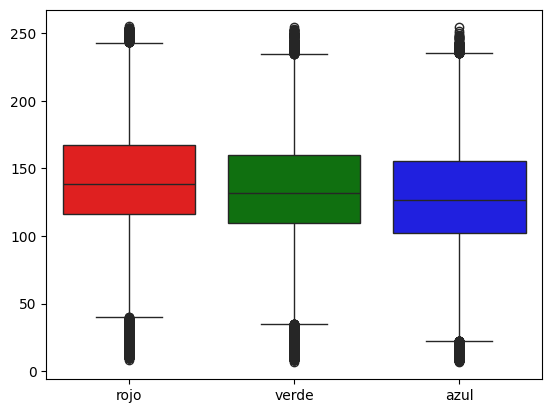

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df[["rojo", "verde", "azul"]],
            palette={"rojo": "red", "verde": "green", "azul": "blue"})
plt.show()

In [10]:
promedios_por_clase = df.groupby("clase")[["rojo", "verde", "azul"]].mean()
print(promedios_por_clase)

                rojo       verde        azul
clase                                       
Casco     144.338366  137.200640  130.343459
No_casco  135.092651  128.991428  124.157792


Las imágenes con casco tienden a tener valores RGB más altos (más claros o brillantes) Esto puede deberse a:

Colores del casco (blanco, amarillo, rojo, etc.)

- Mayor iluminación en zonas donde hay casco (parte superior de la cabeza)

- Menor presencia de sombras oscuras sobre el casco

- Fondo o entorno diferente cuando se usa casco

Al parecer la red CNN podría estar capturando diferencias de color/intensidad como señal para clasificar.

Ver el promedio nos permite saber que colores contiene mas las imagenes

In [ ]:
for color in ["rojo", "verde", "azul"]:
    print(f"\n{color} por clase:")
    print(df.groupby("clase")[color].value_counts())

Cuantos colores por clase hay

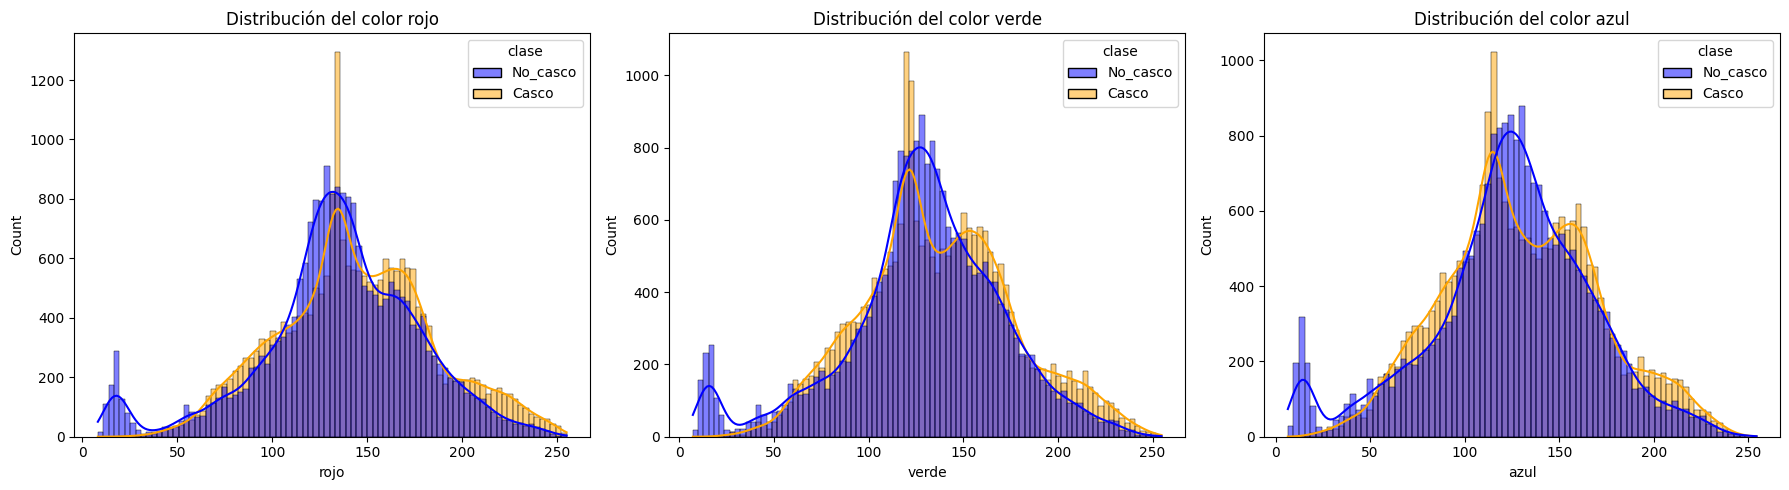

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ["rojo", "verde", "azul"]

for i, color in enumerate(colors):
    sns.histplot(data=df, x=color, hue="clase", ax=axs[i], kde=True, palette={"Casco": "orange", "No_casco": "blue"})
    axs[i].set_title(f"Distribución del color {color}")

plt.tight_layout()
plt.show()

Vemos como entre las dos clases hay diferencias en colores entre la clase Casco y No_casto.

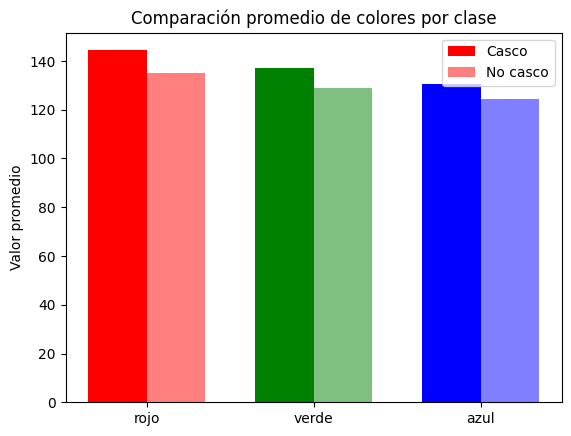

In [14]:
import matplotlib.pyplot as plt
import numpy as np

promedios = promedios_por_clase.T  # Transponer para facilitar plot

fig, ax = plt.subplots()
width = 0.35
x = np.arange(len(promedios.index))

ax.bar(x - width/2, promedios["Casco"], width, label="Casco", color=['red','green','blue'])
ax.bar(x + width/2, promedios["No_casco"], width, label="No casco", color=['red','green','blue'], alpha=0.5)

ax.set_xticks(x)
ax.set_xticklabels(promedios.index)
ax.set_ylabel("Valor promedio")
ax.set_title("Comparación promedio de colores por clase")
ax.legend()

plt.show()

Existe mayor cantidad de colores(Mas brillo), en la clase Casco en comparacion con la clase No_casco lo cual podria indicar que el brillo es un factor importante para 
clasificar las imagenes en ambas clases.

In [16]:
from scipy.stats import ttest_ind

for color in ["rojo", "verde", "azul"]:
    casco = df[df["clase"] == "Casco"][color]
    no_casco = df[df["clase"] == "No_casco"][color]
    stat, p = ttest_ind(casco, no_casco)
    print(f"{color.capitalize()}: p = {p:.4f} {'(diferencia significativa)' if p < 0.05 else '(no significativa)'}")

Rojo: p = 0.0000 (diferencia significativa)
Verde: p = 0.0000 (diferencia significativa)
Azul: p = 0.0000 (diferencia significativa)


Ese resultado indica que las diferencias en los valores promedio de los canales rojo, verde y azul entre imágenes con casco y sin casco son estadísticamente significativas.

Lared neuronal tiene una base real en los datos para diferenciar entre las clases usando información de color. Específicamente:

Rojo: las imágenes con casco tienen más intensidad promedio → quizás cascos rojos o iluminados.

Verde y Azul: también hay más intensidad en la clase “Casco”, lo que puede reflejar mejor iluminación o colores del entorno (chalecos, fondos, etc.).

- En conclusion podemos decir que si existe una diferencia en color en nuestro dataset de No_Casco y Casco